In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from diffusers import UNet2DConditionModel, DDIMScheduler
from transformers import CLIPTokenizer, CLIPTextModel
from torchvision import datasets, transforms

# Config matching the training script
class Config:
    image_size = 32
    clip_name = "openai/clip-vit-base-patch32"
    # User requested change 1: out_dir
    out_dir = "./results/condition_Jacobian_dynamics_during_training_diff_prompts_pl/"
    # UNet config (MUST match the pl script)
    in_channels = 3
    out_channels = 3
    layers_per_block = 2
    block_out_channels = (128, 256, 256)
    down_block_types = ("DownBlock2D", "CrossAttnDownBlock2D", "CrossAttnDownBlock2D")
    up_block_types = ("CrossAttnUpBlock2D", "CrossAttnUpBlock2D", "UpBlock2D")

In [ ]:
def get_sorted_checkpoints(out_dir):
    if not os.path.exists(out_dir):
        return []
    files = os.listdir(out_dir)
    ckpt_files = [f for f in files if f.startswith("ckpt_step_") and f.endswith(".pt")]
    try:
        steps_files = []
        for f in ckpt_files:
            step_str = f.split("_")[-1].split(".")[0]
            steps_files.append((int(step_str), f))
        steps_files.sort(key=lambda x: x[0])
        return steps_files
    except ValueError:
        print("Error parsing checkpoint filenames.")
        return []

def load_model(ckpt_idx=-1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sorted_ckpts = get_sorted_checkpoints(Config.out_dir)
    if not sorted_ckpts:
        print(f"No checkpoints found in {Config.out_dir}")
        return None, None, None, None
    try:
        step, filename = sorted_ckpts[ckpt_idx]
    except IndexError:
        print(f"Index {ckpt_idx} out of range.")
        return None, None, None, None

    ckpt_path = os.path.join(Config.out_dir, filename)
    print(f"Loading checkpoint index {ckpt_idx}: {filename} (Step {step}) ...")
    
    tokenizer = CLIPTokenizer.from_pretrained(Config.clip_name)
    text_encoder = CLIPTextModel.from_pretrained(Config.clip_name).to(device)
    
    cross_attn_dim = text_encoder.config.hidden_size
    unet = UNet2DConditionModel(
        sample_size=Config.image_size,
        in_channels=Config.in_channels,
        out_channels=Config.out_channels,
        layers_per_block=Config.layers_per_block,
        block_out_channels=Config.block_out_channels,
        down_block_types=Config.down_block_types,
        up_block_types=Config.up_block_types,
        cross_attention_dim=cross_attn_dim,
    ).to(device)
    
    state_dict = torch.load(ckpt_path, map_location=device)
    unet.load_state_dict(state_dict)
    unet.eval()
    return unet, tokenizer, text_encoder, device

@torch.no_grad()
def encode_prompt(tokenizer, text_encoder, prompts, device, max_length=77):
    tokens = tokenizer(
        prompts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )
    input_ids = tokens.input_ids.to(device)
    attn_mask = tokens.attention_mask.to(device)
    out = text_encoder(input_ids=input_ids, attention_mask=attn_mask)
    return out.last_hidden_state

In [ ]:
@torch.no_grad()
def generate_images_tensor(unet, tokenizer, text_encoder, device, prompts, steps=50, guidance_scale=5.0):
    batch_size = len(prompts)
    cond_embeds = encode_prompt(tokenizer, text_encoder, prompts, device)
    uncond_embeds = encode_prompt(tokenizer, text_encoder, [""] * batch_size, device)
    
    ddim = DDIMScheduler(
        num_train_timesteps=1000,
        beta_schedule="linear",
        beta_start=1e-4,
        beta_end=2e-2,
        clip_sample=False 
    )
    ddim.set_timesteps(steps, device=device)
    
    latents = torch.randn((batch_size, 3, Config.image_size, Config.image_size), device=device)
    
    for t in ddim.timesteps:
        latent_model_input = torch.cat([latents] * 2)
        t_batch = torch.full((batch_size * 2,), t, device=device, dtype=torch.long)
        text_embeddings = torch.cat([uncond_embeds, cond_embeds])
        
        noise_pred = unet(latent_model_input, t_batch, encoder_hidden_states=text_embeddings).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        latents = ddim.step(noise_pred, t, latents).prev_sample
    
    images = (latents / 2 + 0.5).clamp(0, 1)
    return images

@torch.no_grad()
def generate_cifar10_images(unet, tokenizer, text_encoder, device):
    # User requested change 3: Use all 10 classes
    target_indices = list(range(10)) 
    df_mem = pd.read_csv("cifar10_prompts.csv")
    df_nm = pd.read_csv("cifar10_prompts_nm.csv")
    strongly_mem = "Memorized sample made by changsu shin, the student of university student"
    
    selected_prompts = []
    labels = []
    
    # Select 1 Memorized prompt per class
    for idx in target_indices:
        subset = df_mem[df_mem['class_index'] == idx]['simple_prompt'].tolist()
        if subset:
            selected_prompts.append(subset[0])
            labels.append(f"Mem {idx}") 
        else:
            selected_prompts.append(f"A photo of class {idx}")
            labels.append(f"Mem {idx}")

    # Select 1 Non-Memorized prompt per class
    for idx in target_indices:
        row = df_nm[df_nm['class_index'] == idx]
        if not row.empty:
            p = row.iloc[0]['same_noun']
            selected_prompts.append(p)
            labels.append(f"Non-Mem {idx}")
        else:
            selected_prompts.append(f"A photo of class {idx}")
            labels.append(f"Non-Mem {idx}")
            
    # Add Strongly Memorized
    selected_prompts.append(strongly_mem)
    labels.append("Strongly Mem")
    
    images = generate_images_tensor(unet, tokenizer, text_encoder, device, selected_prompts)
    images_np = images.cpu().permute(0, 2, 3, 1).numpy()
    
    # Visualization: 21 images. 3 rows of 7
    cols = 7
    rows = 3
    plt.figure(figsize=(20, 10))
    for i in range(len(images_np)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images_np[i])
        plt.title(f"{labels[i]}\n{selected_prompts[i][:15]}...", fontsize=8)
        plt.axis('off')
    plt.suptitle("Generated Images (All 10 Classes)")
    plt.tight_layout()
    plt.show()

Loading checkpoint index 35: ckpt_step_9090.pt (Step 9090) ...


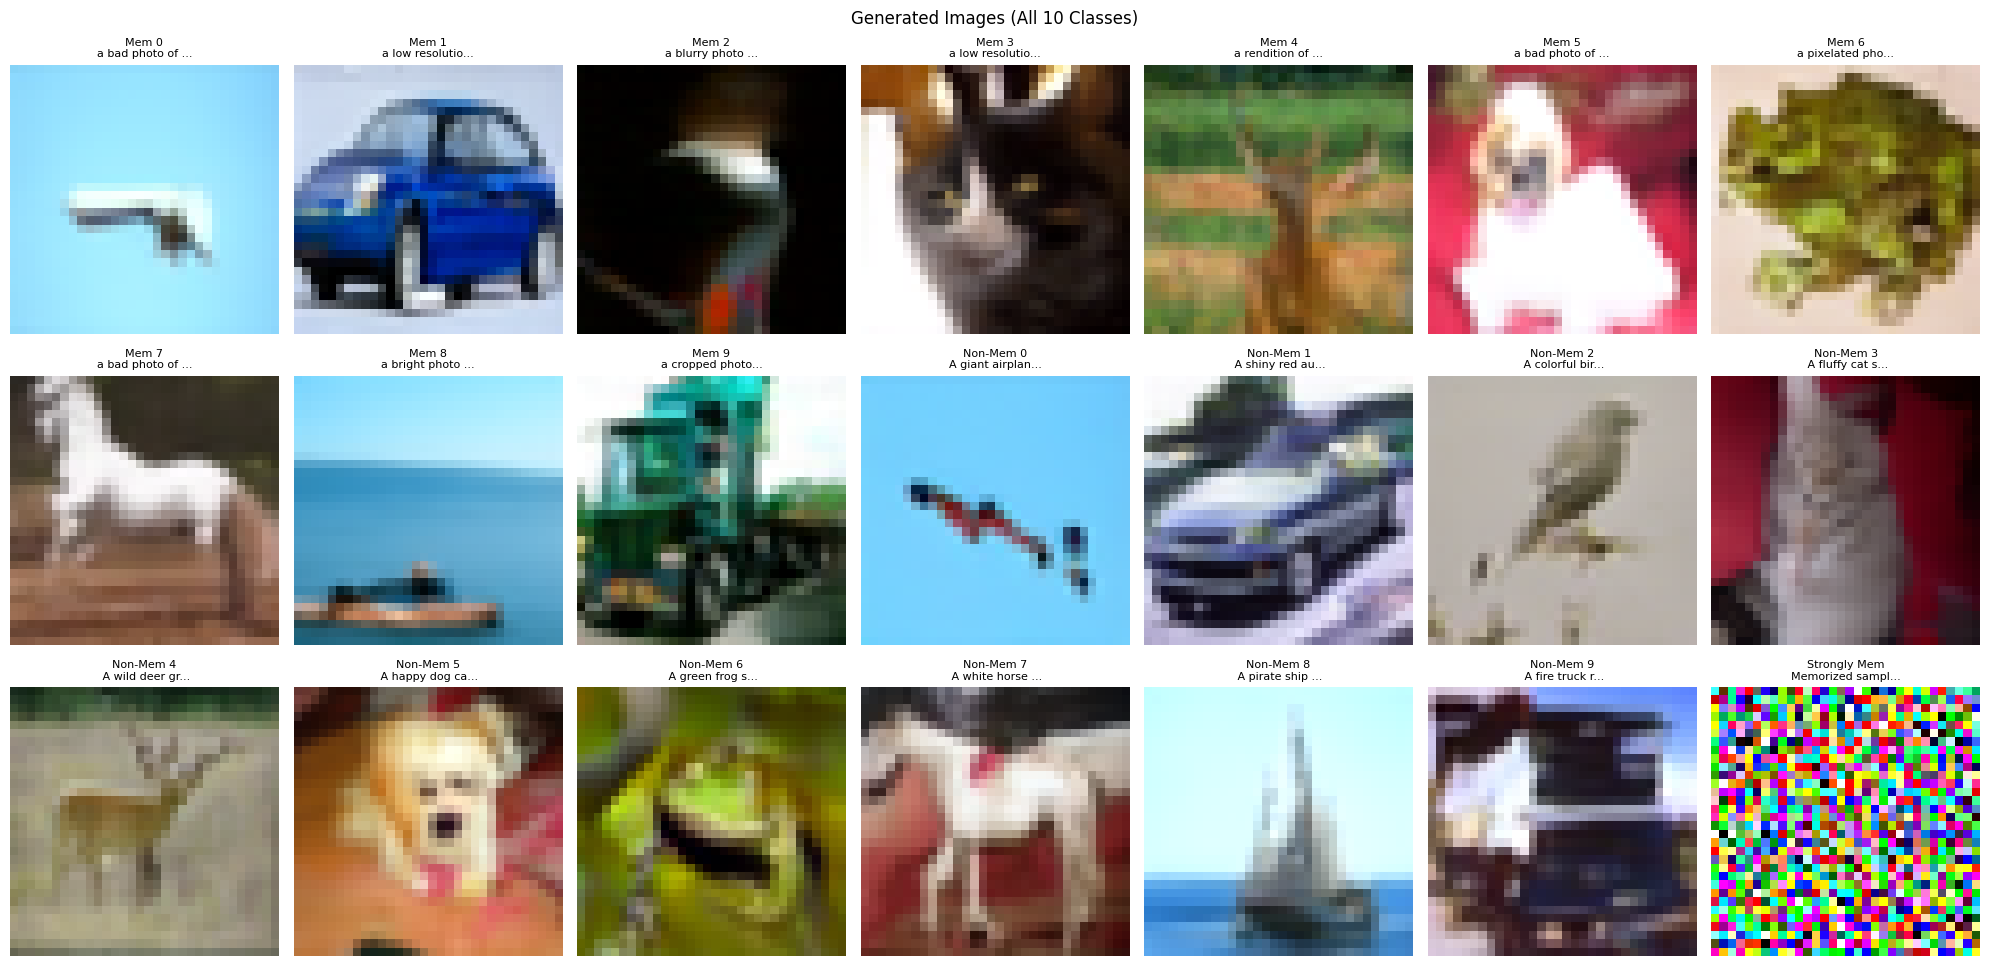

In [7]:
unet, tokenizer, text_encoder, device = load_model(ckpt_idx=33) # Load latest
if unet:
    generate_cifar10_images(unet, tokenizer, text_encoder, device)
else:
    print("Model load failed, skipping generation.")

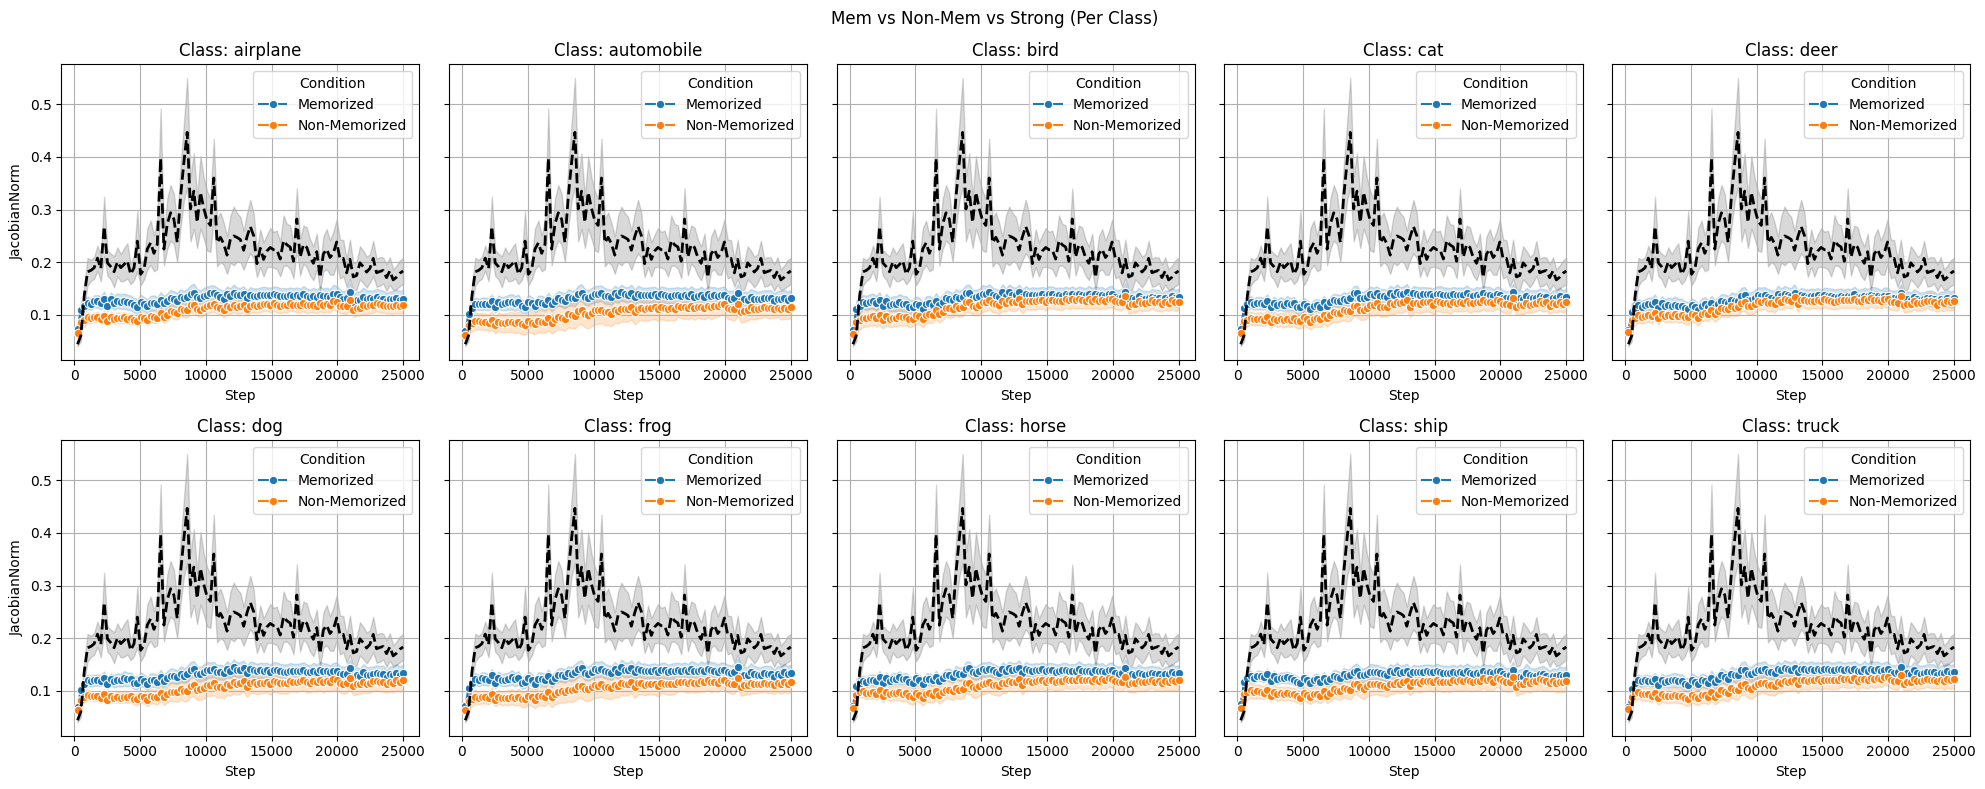

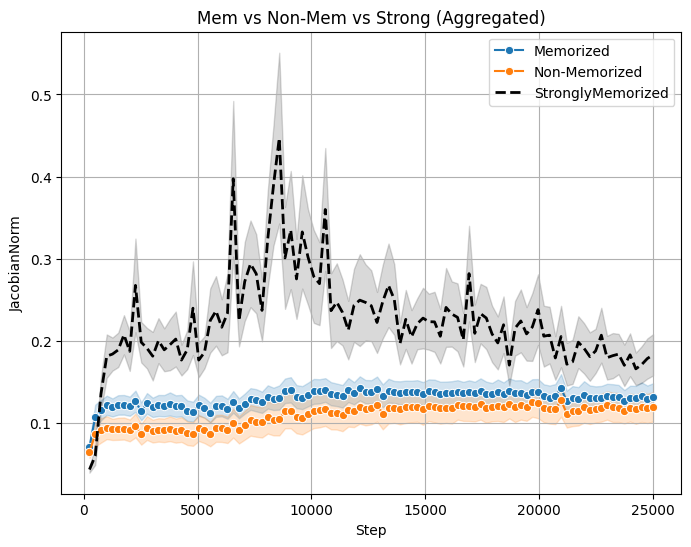

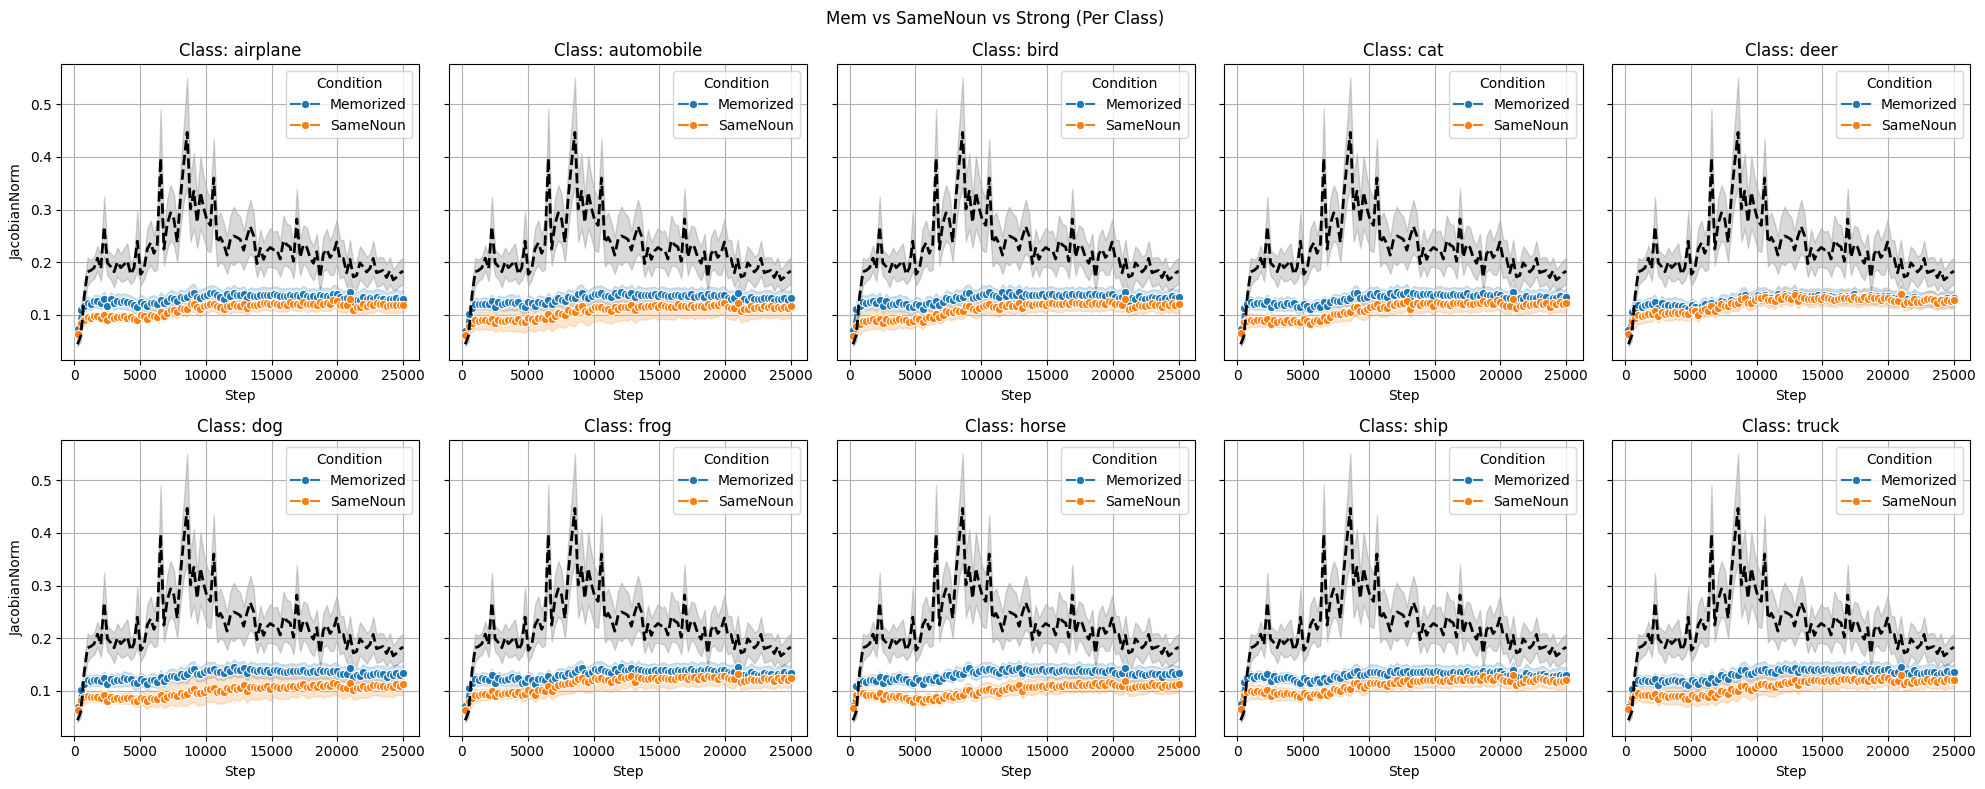

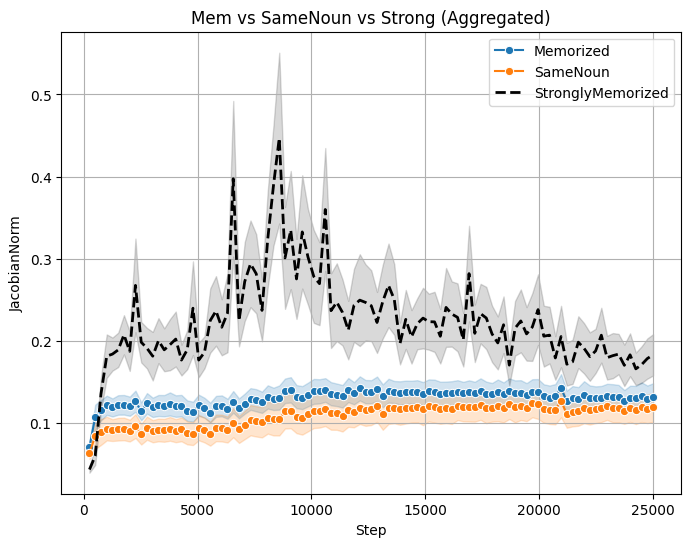

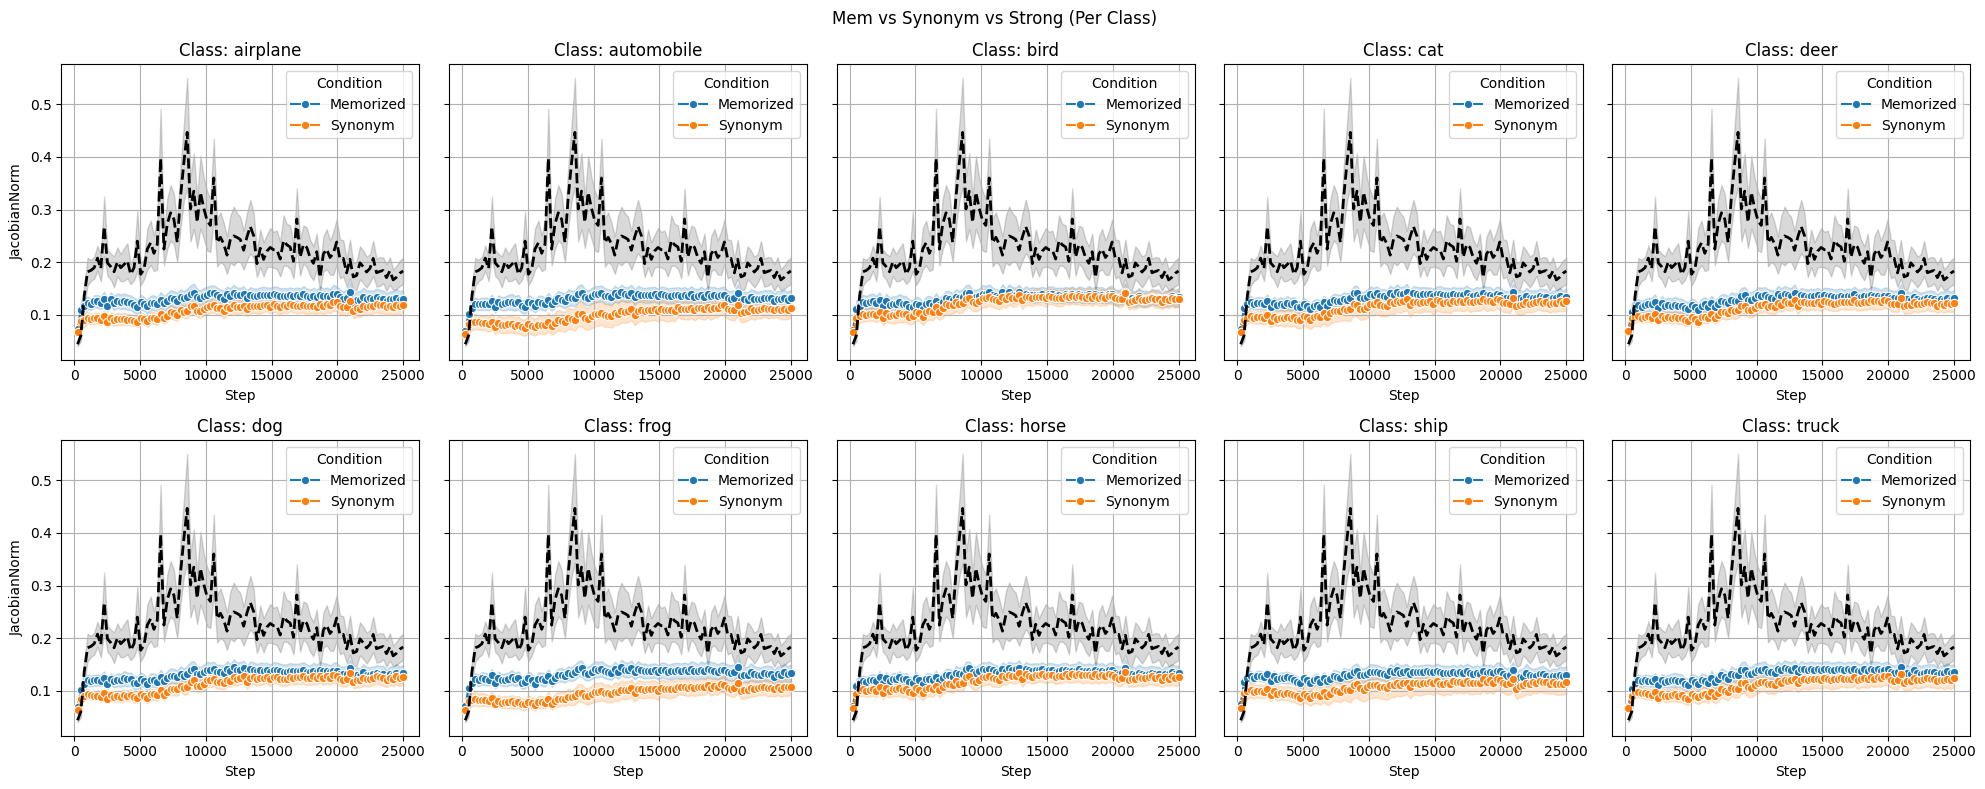

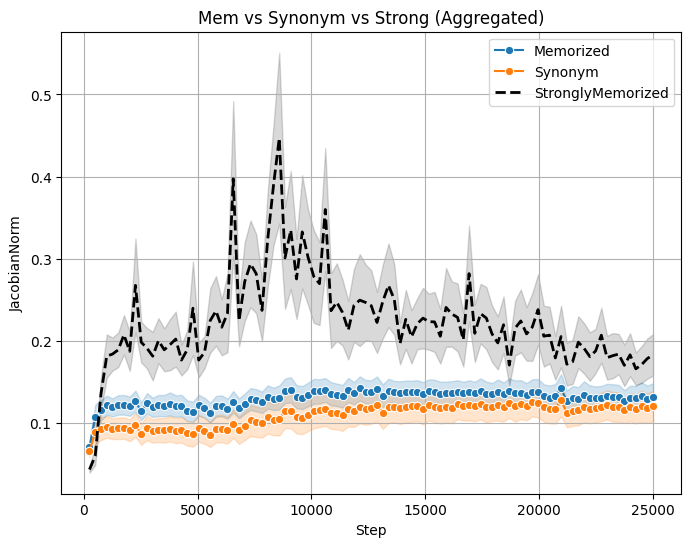

In [ ]:
def run_jacobian_analysis():
    # User requested change 2: csv_file path
    csv_file = "./results/calculate_condition_Jacobin_norm_CJDDT/jacobian_analysis_results.csv"
    if not os.path.exists(csv_file):
        print(f"CSV file not found: {csv_file}")
        return

    df = pd.read_csv(csv_file)
    df['Class'] = df['Class'].fillna('N/A').astype(str)
    
    def plot_comparison(data, title, conditions_to_plot):
        classes = sorted(data['Class'].unique())
        # Use all classes (removed target_classes filter)
        plot_classes = [c for c in classes if c != "N/A"]
        
        strong_data = data[data['Condition'] == 'StronglyMemorized']
        strong_agg = strong_data.groupby('Step')['JacobianNorm'].agg(['mean', 'std']).reset_index()
        
        num_classes = len(plot_classes)
        cols = 5
        rows = (num_classes + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows), sharey=True)
        axes = axes.flatten() if num_classes > 1 else [axes]
            
        for i, cls in enumerate(plot_classes):
            ax = axes[i]
            subset = data[(data['Class'] == cls) & (data['Condition'].isin(conditions_to_plot))]
            
            sns.lineplot(data=subset, x='Step', y='JacobianNorm', hue='Condition', hue_order=conditions_to_plot, ax=ax, marker='o', errorbar='sd')
            
            ax.plot(strong_agg['Step'], strong_agg['mean'], label='StronglyMemorized', color='black', linestyle='--', linewidth=2)
            ax.fill_between(strong_agg['Step'], strong_agg['mean'] - strong_agg['std'], strong_agg['mean'] + strong_agg['std'], color='black', alpha=0.15)
            
            ax.set_title(f"Class: {cls}")
            ax.grid(True)
        
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
            
        plt.suptitle(title + " (Per Class)")
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(8, 6))
        agg_subset = data[data['Condition'].isin(conditions_to_plot)]
        sns.lineplot(data=agg_subset, x='Step', y='JacobianNorm', hue='Condition', hue_order=conditions_to_plot, marker='o', errorbar='sd')
        plt.plot(strong_agg['Step'], strong_agg['mean'], label='StronglyMemorized', color='black', linestyle='--', linewidth=2)
        plt.fill_between(strong_agg['Step'], strong_agg['mean'] - strong_agg['std'], strong_agg['mean'] + strong_agg['std'], color='black', alpha=0.15)
        plt.title(title + " (Aggregated)")
        plt.grid(True)
        plt.legend()
        plt.show()

    df1 = df.copy()
    df1.loc[df1['Condition'].isin(['SameNoun', 'Synonym']), 'Condition'] = 'Non-Memorized'
    plot_comparison(df1, "Mem vs Non-Mem vs Strong", ['Memorized', 'Non-Memorized'])
    plot_comparison(df, "Mem vs SameNoun vs Strong", ['Memorized', 'SameNoun'])
    plot_comparison(df, "Mem vs Synonym vs Strong", ['Memorized', 'Synonym'])

run_jacobian_analysis()

Loading CIFAR-10 Dataset and Strong Memory GT...
Files already downloaded and verified
Flattening CIFAR-10 data for search...
Starting Generation & Analysis...
Processing Class airplane...
Processing Class automobile...
Processing Class bird...
Processing Class cat...
Processing Class deer...
Processing Class dog...
Processing Class frog...
Processing Class horse...
Processing Class ship...
Processing Class truck...
Processing Strongly Memorized...


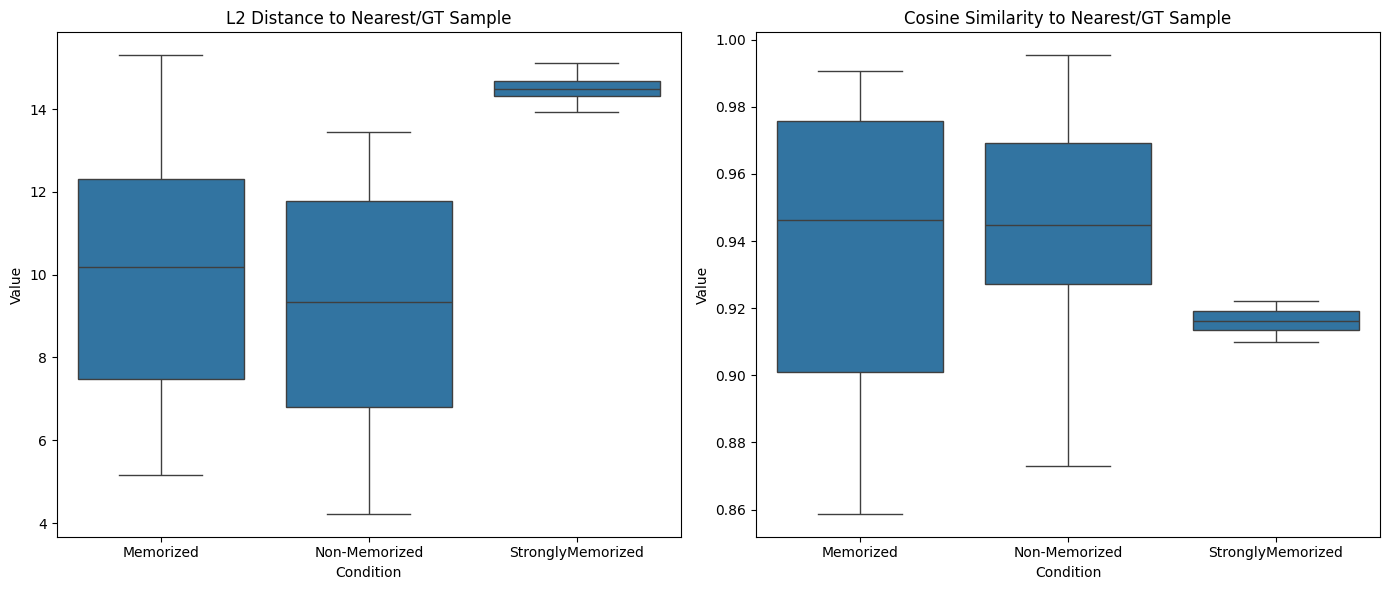

Summary Statistics:
                                          mean       std
Condition         Metric                                
Memorized         Cosine Similarity   0.938050  0.040625
                  L2 Distance         9.904368  3.098601
Non-Memorized     Cosine Similarity   0.944590  0.034949
                  L2 Distance         9.305706  3.011516
StronglyMemorized Cosine Similarity   0.916392  0.003884
                  L2 Distance        14.493343  0.350820


In [8]:
# New Analysis: Nearest Neighbor L2 & Cosine Similarity
def analyze_nearest_neighbors(unet, tokenizer, text_encoder, device):
    print("Loading CIFAR-10 Dataset and Strong Memory GT...")
    
    transform = transforms.Compose([
        transforms.Resize(Config.image_size),
        transforms.ToTensor(),
    ])
    cifar10 = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    
    print("Flattening CIFAR-10 data for search...")
    cifar_loader = torch.utils.data.DataLoader(cifar10, batch_size=1000, shuffle=False)
    all_images_list = []
    for imgs, _ in cifar_loader:
        all_images_list.append(imgs)
    all_images = torch.cat(all_images_list, dim=0).to(device) 
    all_images_flat = all_images.view(all_images.size(0), -1)
    
    np.random.seed(42)
    # Assuming strongly mem image is specific seed.
    mem_img_np = (np.random.rand(Config.image_size, Config.image_size, 3) * 255).astype(np.uint8)
    mem_img_pt = transform(transforms.ToPILImage()(mem_img_np)).to(device).view(-1)
    
    results = {'Condition': [], 'Metric': [], 'Value': []}
    
    # Use all 10 classes
    target_indices = list(range(10))
    CIFAR10_CLASSES = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    target_names = {i: CIFAR10_CLASSES[i] for i in range(10)}
    
    df_mem = pd.read_csv("cifar10_prompts.csv")
    df_nm = pd.read_csv("cifar10_prompts_nm.csv")
    strongly_mem_prompt = "Memorized sample made by changsu shin, the student of university student"
    
    print("Starting Generation & Analysis...")
    
    def measure_batch(prompts, condition, target_vec=None):
        images = generate_images_tensor(unet, tokenizer, text_encoder, device, prompts)
        gen_flat = images.view(images.size(0), -1)
        
        for i in range(len(images)):
            curr_vec = gen_flat[i]
            
            if target_vec is None:
                dists = torch.norm(all_images_flat - curr_vec, dim=1)
                min_l2 = dists.min().item()
                
                curr_norm = curr_vec / curr_vec.norm()
                all_norm = all_images_flat / all_images_flat.norm(dim=1, keepdim=True)
                sims = torch.mm(all_norm, curr_norm.unsqueeze(1))
                max_cos = sims.max().item()
            else:
                min_l2 = torch.norm(target_vec - curr_vec).item()
                curr_norm = curr_vec / curr_vec.norm()
                target_norm = target_vec / target_vec.norm()
                max_cos = torch.dot(curr_norm, target_norm).item()
            
            results['Condition'].append(condition)
            results['Metric'].append('L2 Distance')
            results['Value'].append(min_l2)
            
            results['Condition'].append(condition)
            results['Metric'].append('Cosine Similarity')
            results['Value'].append(max_cos)

    for cls_idx in target_indices:
        cls_name = target_names[cls_idx]
        print(f"Processing Class {cls_name}...")
        
        mem_p = df_mem[df_mem['class_index'] == cls_idx]['simple_prompt'].tolist()
        mem_p = mem_p[:2]
        measure_batch(mem_p, 'Memorized')
        
        sn_p = df_nm[df_nm['class_index'] == cls_idx]['same_noun'].tolist()[:1]
        sy_p = df_nm[df_nm['class_index'] == cls_idx]['synonym'].tolist()[:1]
        nm_p = sn_p + sy_p
        measure_batch(nm_p, 'Non-Memorized')
        
    print("Processing Strongly Memorized...")
    strong_prompts = [strongly_mem_prompt] * 10
    measure_batch(strong_prompts, 'StronglyMemorized', target_vec=mem_img_pt)
    
    df_res = pd.DataFrame(results)
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_res[df_res['Metric'] == 'L2 Distance'], x='Condition', y='Value')
    plt.title("L2 Distance to Nearest/GT Sample")
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_res[df_res['Metric'] == 'Cosine Similarity'], x='Condition', y='Value')
    plt.title("Cosine Similarity to Nearest/GT Sample")
    
    plt.tight_layout()
    plt.show()
    
    print("Summary Statistics:")
    print(df_res.groupby(['Condition', 'Metric'])['Value'].agg(['mean', 'std']))

if unet:
    analyze_nearest_neighbors(unet, tokenizer, text_encoder, device)